In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os
%matplotlib inline

In [65]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# Build content and style losses

In [66]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super().__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [67]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size() #batch_size, 
        features = input.view(a*b, c*d)
        G = torch.mm(features, features.t())
        return G.div(a*b*c*d)

In [68]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super().__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

# Load pre-trained model and build transfer model

In [69]:
vgg = models.vgg19(pretrained=True).features
if use_cuda:
    vgg.cuda()

In [70]:
def build_model(vgg, style_img, content_img, params):
    """inputs: model to extract features, image variables """
    vgg = copy.deepcopy(vgg)
    content_losses = []
    style_losses = []
    
    model = nn.Sequential().cuda() if use_cuda else nn.Sequential()
    gram = GramMatrix().cuda() if use_cuda else GramMatrix()

    i = 1
    for layer in list(vgg):
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)

            if name in params["content_layers"]:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, params["content_weight"])
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)

            if name in params["style_layers"]:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, params["style_weight"])
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)

            if name in params["content_layers"]:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)

            if name in params["style_layers"]:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, params["style_weight"])
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
                
            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)

    return model, style_losses, content_losses    

# Load images

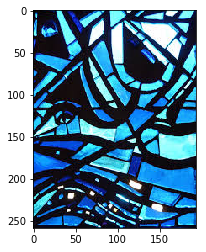

In [71]:
style = 'img/style.jpeg'
style_img = plt.imread(style)
plt.imshow(style_img)

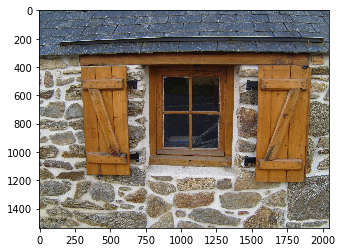

In [72]:
window = 'img/window.jpg'
door = 'img/door.jpeg'
window_img = plt.imread(window)
plt.imshow(window_img)

In [73]:
def load_image(img_name, params):
    """input: image_name str, output: torch variable"""
    transform = transforms.Compose([transforms.Scale(params['img_size']), 
                                    transforms.ToTensor()])
    img = Image.open(img_name) 
    img = Variable(transform(img))
    img = img.unsqueeze(0) #because batch-size is added by default
    return img

In [74]:
def load_data(content_name, style_name, params):
    """input: name strings, output: torch variables"""
    print("Loading data")
    content_img = load_image(content_name, params).type(dtype)
    style_img = load_image(style_name, params).type(dtype)
    assert style_img.size() == content_img.size(), "the sizes of style and content images are different"
    input_img = content_img.clone()
    print("Data loaded")
    return content_img, style_img, input_img

# Train model and display results

In [75]:
def train_model(vgg, style_img, content_img, input_img, opt, params):
    
    print("Building model and optimizer")
    model, style_losses, content_losses = build_model(vgg, style_img, content_img, params)
    input_param = nn.Parameter(input_img.data)
    
#     best_model_wts = model.state_dict()
#     best_loss = float('inf')
    
    if opt == "LBFGS":        
        optimizer = optim.LBFGS([input_param])
        print("Model and LBFGS optimizer built")

    elif opt == "Adam":
        optimizer = torch.optim.Adam([input_param], lr=params['lr'], betas=params['betas'])
        print("Model and Adam optimizer built")
 
    print('Optimizing')    
    
    for epoch in range(params['num_epochs']):
        # model.load_state_dict(best_model_wts)
        
        def closure():
            input_param.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_param)

            style_score = 0
            content_score = 0

            for style_loss in style_losses:
                style_score += style_loss.backward()

            for content_loss in content_losses:
                content_score += content_loss.backward()

            if epoch % 20 == 0 or epoch == (params['num_epochs'] - 1):
                print('Epoch {}: Style Loss : {:4f} Content Loss: {:4f}'.format(epoch, style_score.data[0], content_score.data[0]))
             
            return style_score + content_score
           
        if opt == "LBFGS":            
            optimizer.step(closure)
               
        elif opt == 'Adam':
            loss = closure().data[0]
            optimizer.step()
            
#         if loss < best_loss:        
#             best_loss = loss
#             best_model_wts = model.state_dict()

#   print("Optimizing finished, smallest loss: ", best_loss)
    print("Optimizing finished")    
    
    input_param.data.clamp_(0, 1)
    output = input_param
    return output.data

In [76]:
unloader = transforms.ToPILImage()

def unload_tensor(tensor, params):
    #img = variable.data #tensor
    img = tensor.clone().cpu()
    img = img.view(3, *params['img_size'])
    img = unloader(img)
    return img

def display_images(content_variable, style_variable, output_tensor, params):
    
    images = [content_variable.data, style_variable.data, output_tensor]
    images_unloaded = [unload_tensor(x, params) for x in images]
    titles = ['Content', 'Style', 'Output']    
    fig = plt.figure()
    for idx, (img, title) in enumerate(zip(images_unloaded, titles)):
        ax = fig.add_subplot(1,3,idx+1)
        ax.set_axis_off()
        ax.set_title(title)
        ax.imshow(img)

# Generate images

In [77]:
hparams1 = {
'img_size': (512, 512) if use_cuda else (128, 128), 
'content_layers': ['conv_4'], 
'style_layers': ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'], 
'style_weight': 500, 
'content_weight': 1, 
'num_epochs': 280, 
'lr': 0.09, 
'betas': [0.5, 0.999]
}
content_variable, style_variable, input_variable = load_data(window, style, hparams1)    
output_tensor1 = train_model(vgg, style_variable, content_variable, input_variable, "Adam", params=hparams1)

Loading data
Data loaded
Building model and optimizer
Model and Adam optimizer built
Optimizing
Epoch 0: Style Loss : 119.610931 Content Loss: 0.000000


/home/jupyter/.virtualenvs/dong/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


Epoch 20: Style Loss : 29.170628 Content Loss: 3.558235
Epoch 40: Style Loss : 581.979248 Content Loss: 6.934171
Epoch 60: Style Loss : 21.459961 Content Loss: 4.413331
Epoch 80: Style Loss : 10.715151 Content Loss: 3.853781
Epoch 100: Style Loss : 7.581370 Content Loss: 3.597714
Epoch 120: Style Loss : 5.931594 Content Loss: 3.429256
Epoch 140: Style Loss : 4.826735 Content Loss: 3.303433
Epoch 160: Style Loss : 4.000097 Content Loss: 3.208958
Epoch 180: Style Loss : 3.342331 Content Loss: 3.131334
Epoch 200: Style Loss : 2.814682 Content Loss: 3.068991
Epoch 220: Style Loss : 2.390283 Content Loss: 3.018667
Epoch 240: Style Loss : 2.056415 Content Loss: 2.977324
Epoch 260: Style Loss : 1.759142 Content Loss: 2.937812
Epoch 279: Style Loss : 3.429772 Content Loss: 2.907523
Optimizing finished


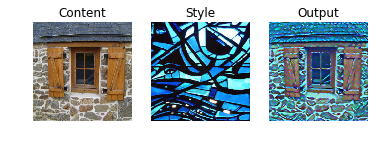

In [78]:
display_images(content_variable, style_variable, output_tensor1, hparams1)

In [79]:
hparams2 = {
'img_size': (512, 512) if use_cuda else (128, 128), 
'content_layers': ['conv_4'], 
'style_layers': ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'], 
'style_weight': 1000, 
'content_weight': 1, 
'num_epochs': 40, 
'lr': 0.09, 
'betas': [0.5, 0.999]
}

content_variable, style_variable, input_variable = load_data(door, style, hparams2)    
output_tensor2 = train_model(vgg, style_variable, content_variable, input_variable, "LBFGS", hparams2)

Loading data
Data loaded
Building model and optimizer
Model and LBFGS optimizer built
Optimizing


/home/jupyter/.virtualenvs/dong/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


Epoch 0: Style Loss : 560.432312 Content Loss: 0.000000
Epoch 0: Style Loss : 560.401062 Content Loss: 0.000000
Epoch 0: Style Loss : 467.942383 Content Loss: 1.389047
Epoch 0: Style Loss : 342.013977 Content Loss: 1.730789
Epoch 0: Style Loss : 257.831970 Content Loss: 1.695208
Epoch 0: Style Loss : 200.134308 Content Loss: 1.862625
Epoch 0: Style Loss : 166.753128 Content Loss: 2.128532
Epoch 0: Style Loss : 148.747498 Content Loss: 2.150080
Epoch 0: Style Loss : 133.669281 Content Loss: 2.261564
Epoch 0: Style Loss : 120.557541 Content Loss: 2.385615
Epoch 0: Style Loss : 110.164558 Content Loss: 2.597693
Epoch 0: Style Loss : 102.199333 Content Loss: 2.582524
Epoch 0: Style Loss : 95.378319 Content Loss: 2.708352
Epoch 0: Style Loss : 89.476761 Content Loss: 2.837911
Epoch 0: Style Loss : 83.293068 Content Loss: 2.958074
Epoch 0: Style Loss : 77.994598 Content Loss: 2.954005
Epoch 0: Style Loss : 73.637695 Content Loss: 3.119957
Epoch 0: Style Loss : 69.779579 Content Loss: 3.12677

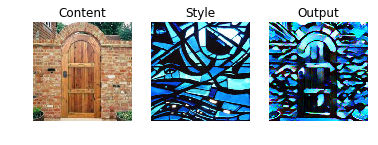

In [80]:
display_images(content_variable, style_variable, output_tensor2, hparams2)

In [ ]:
# !nvidia-smi